# [실습] BERT Pretraining 하기

### 실습 목차
* 1. BERT 모델 구조
  * 1-1. Bert 모델 불러오기
  * 1-2. BertEmbeddings 구조
    * 1-2-1. Token Embeddings 구조
    * 1-2-2. Segment Embeddings 구조
    * 1-2-3. Position Embeddings 구조
  * 1-3. BertEncoder 구조
    * 1-3-1. BertLayer 구조
* 2. BERT Pre-training
  * 2-1. Masked Language Modeling
  * 2-2. Next Sentence Prediction

In [1]:
# 라이브러리 import
import torch
import random
import numpy as np

from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction

2024-08-28 16:39:36.362166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 16:39:36.432703: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 16:39:36.715454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-08-28 16:39:36.715503: W tensorflow/compiler/xl

- `bert-base-uncased` : Tokenize를 할 때, 대소문자를 구분하려면 `cased`, 모두 소문자로 변환하려면 `uncased` 사용합니다.
- `add_pooling_layer` : BERT 위에 추가적으로 pooling layer를 쌓을 것인지 여부를 결정합니다. pooling layer는 `[CLS]` token의 embedding만을 뽑아 linear 연산과 activation 연산을 수행하는 layer로, BERT를 이용해 classification task를 수행할 때 주로 사용합니다.
- `output_hidden_states` : BERT의 각 layer의 hidden state들을 출력할 것인지 여부를 결정합니다.(즉, 12개의 encoder layer가 출력한 hidden_state를 모두 반환.)
- `ouput_attentions` : BERT의 각 layer의 attention weight들을 출력할 것인지 여부를 결정합니다.(12개의 encoder layer가 출력한 attention_weight를 모두 반환.)

In [2]:
# bert-base 모델 불러오기
model = BertModel.from_pretrained("bert-base-uncased",
                                  add_pooling_layer=False,
                                  output_hidden_states=True,
                                  output_attentions=True)

In [3]:
# bert의 총 파라미터 수
model.num_parameters()

108891648

In [4]:
# bert 모델 전체 구조
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### 1-2. BertEmbeddings 구조


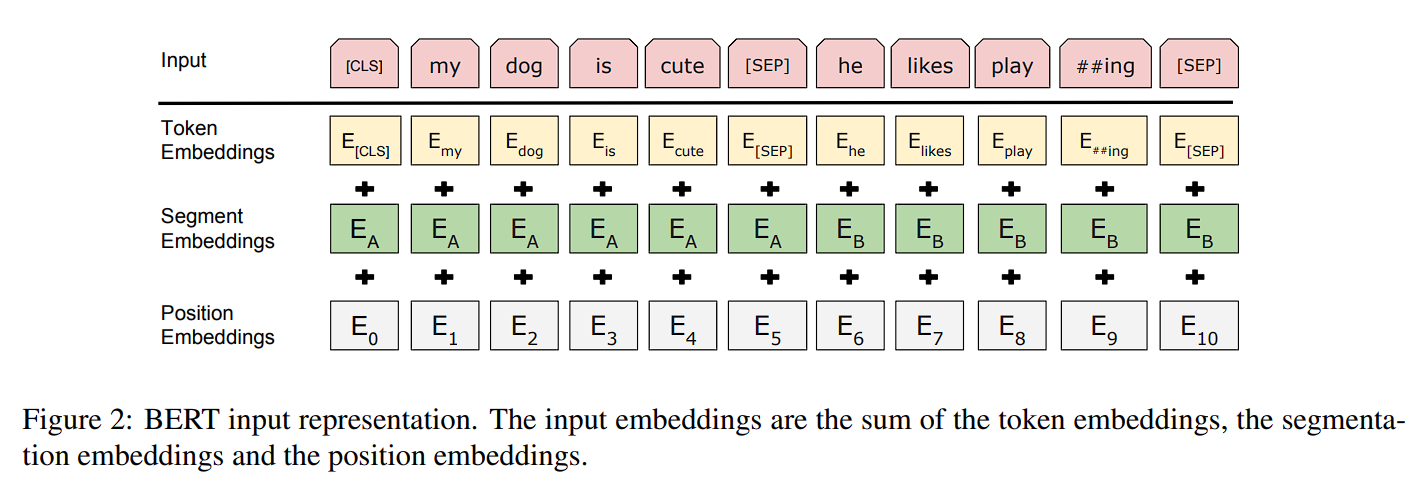


#### 1-2-1. Token Embeddings 구조
서브워드 토크나이저(subword tokenizer)를 사용하여 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩합니다. 토큰화를 통해 BERT는 30,522 크기의 단어 집합을 가집니다.

In [5]:
## vocab에 등록된 단어 수 : 30522
## 각각의 단어가 768차원의 벡터.

model.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

#### 1-2-2. Segment Embeddings 구조
각 token이 어떤 문장에 속하는지를 나타내는 리스트입니다. BERT는 한 번에 두 문장(sentence A, sentence B)을 입력으로 받았을 때, sentence A에 속하는 token에는 0을, sentence B에 속하는 token에는 1을 부여합니다.

In [6]:
model.embeddings.token_type_embeddings

Embedding(2, 768)

##### Tokenization 작동 방식 예시

In [7]:
# BERT 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer("I love NLP!", "I love ai")

print("input ids : ", tokens['input_ids']) ## 각 토큰이 가진 vocab내 idx
print("token_type_ids: ", tokens['token_type_ids']) ## segment embedding
print("input_tokens : ", tokenizer.convert_ids_to_tokens(tokens['input_ids'])) ## 토크나이저가 special tokens를 알아서 집어넣어준다.
print("lenght of input_tokens : ", len(tokenizer.convert_ids_to_tokens(tokens['input_ids'])))

input ids :  [101, 1045, 2293, 17953, 2361, 999, 102, 1045, 2293, 9932, 102]
token_type_ids:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
input_tokens :  ['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]', 'i', 'love', 'ai', '[SEP]']
lenght of input_tokens :  11


- `input_ids` : 입력 문장이 토큰화된 각 token들의 id 리스트입니다. <br>
- `token_type_ids`: 각 token이 어떤 문장에 속하는지를 나타내는 리스트
- `input_tokens`: [CLS], [SEP]과 같이 원문("I love NLP!")에는 없던 토큰들이 추가되었습니다. 이는 BERT가 사용하는 special token들로, tokenization 과정에서 추후 작업에 사용될 토큰들을 자동으로 추가한 것입니다. <br>

#### 1-2-3. Position Embeddings 구조
토큰의 위치 정보를 위한 임베딩 층으로 학습을 통해 위치 정보를 얻습니다. BERT에선 문장의 최대 길이를 512로 하므로 총 512개의 포지션 임베딩 벡터가 학습됩니다.

In [8]:
## BERT의 최대 문장 길이는 512, 각각의 단어 임베딩 벡터에 더해져야 하므로 768차원을 갖게 된다.
## 즉, 입력된 시퀀스의 길이도 512이고 각 단어에 대한 임베딩 벡터는 (1, 768)이다. --> (512, 768)
model.embeddings.position_embeddings

Embedding(512, 768)

### 1-3.BertEncoder 구조


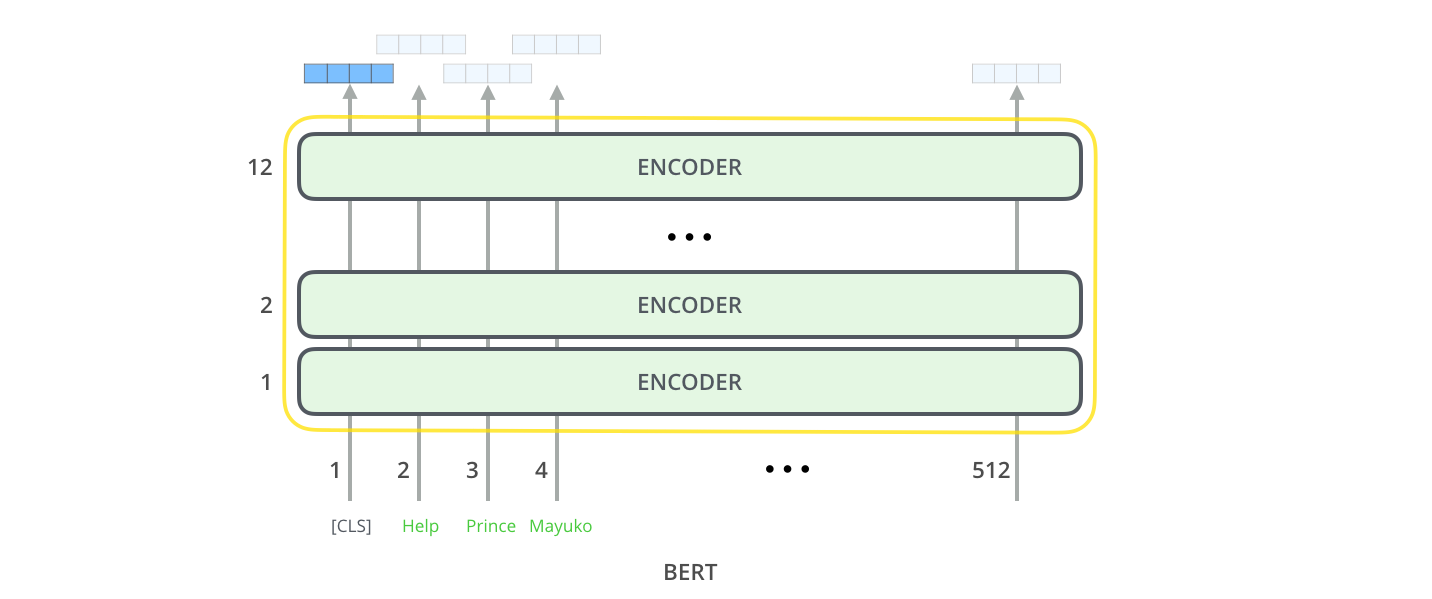

- 12개의 transformer encoder들
- 각각의 encoder는 BertLayer로 구성된다.

#### 1-3-1 BertLayer 구조
 - 양방향 문맥 정보가 반영된 임베딩을 생성합니다. `embeddings` 모듈의 출력값을 입력으로 받아 `encoder_output`이라는 출력값을 반환합니다. <br>
 - Transformer encoder 기반으로 구성된 12개의 Bertlayer로 이루어져 있습니다.



In [ ]:
# bert encoder layer의 출력값 확인
model_input = tokenizer("I love NLP!" , "I love ai", return_tensors="pt") ## 문장 토큰화 수행.
output = model(**model_input) ## 모델에 입력

print("BERT의 총 hidden_states 개수: ", len(output.hidden_states)) ## BERT Embedding의 hidden state 1개 + BERT Encoder의 hidden state 12개
print("Encoder layer의 출력 형태: ", output.last_hidden_state.shape) ## 예시로 사용한 문장은 토크나이저에 의해 11개의 토큰으로 분할되었고 마지막 encoder의 출력이므로 (1, 11, 768)

## Pretraining, Finetuning을 수행할 때는 last_hidden_state를 가지고 한다.

BERT의 총 hidden_states 개수:  13
Encoder layer의 출력 형태:  torch.Size([1, 11, 768])


- `hidden_states`: 각 layer의 hidden state를 모아놓은 리스트입니다. embedding layer와 함께 총 13개의 hidden_states를 가집니다.
- `last_hidden_state`: 마지막 hidden state를 출력합니다. 최종적으로 각 토큰마다 768차원의 임베딩 벡터를 출력합니다.

## 2. BERT Pretraining


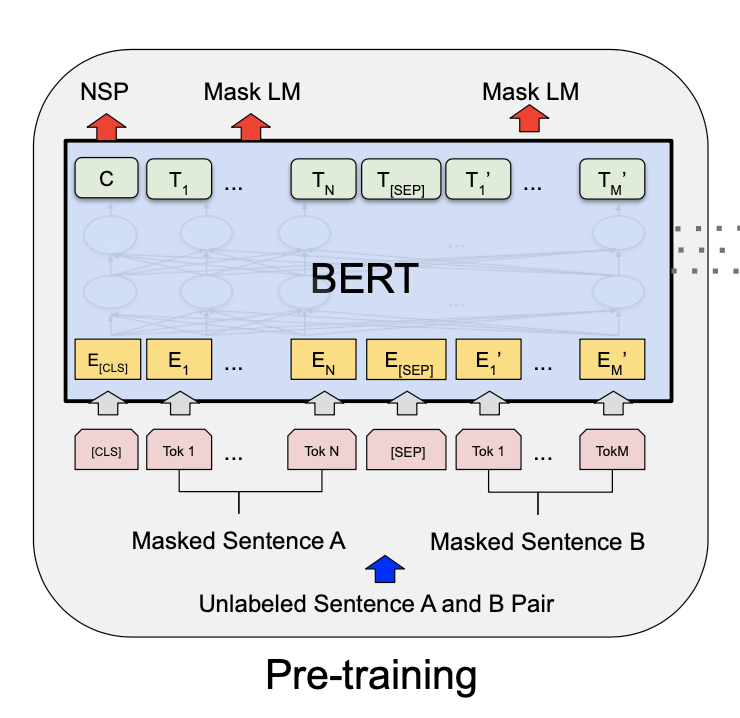



훈련시킬 데이터를 모두 인코딩하였으면, 인코딩 된 데이터들을 가지고서 모델을 사전 학습 시켜야합니다. BERT에서는 MLM(Masked Language Modeling)과 NLP(Next Sentence Prediction) 2가지 방식을 통해 사전 학습합니다.





### 2-1. Masked Language Modeling (MLM) task

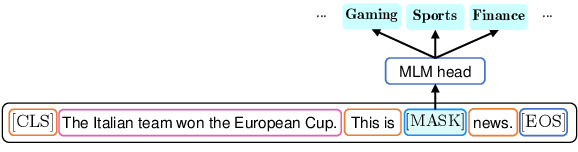

- BERT는 사전 훈련을 위해 입력 텍스트의 15% 단어를 랜덤으로 마스킹합니다. 이후 신경망이 가려진 단어들을 예측하도록 합니다.

MLM 작업을 위한 `BertForMaskedLM`모델을 불러옵니다. [MASK]라고 되어있는 단어를 맞추기 위한 마스크드 언어 모델링 구조를 가진 모델입니다.

In [ ]:
## MLM 작업을 위한 모델 BertForMaskedLM 불러오기
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MLM 작업을 위해 임시로 사용할 문장을 설정합니다.

In [ ]:
text = """
Squid Game was released worldwide on September 17, 2021, to critical acclaim and
international attention. It is Netflix's most-watched series, becoming
the top-viewed program in 94 countries and attracting more than 142 million
member households and amassing 1.65 billion viewing hours during its first four
weeks from launch, surpassing Bridgerton for the title of most watched show.
The series has also received numerous accolades, including the Golden Globe
Award for Best Supporting Actor – Series, Miniseries or Television Film for
O Yeong-su and the Screen Actors Guild Award for Outstanding Performance by a
Male Actor in a Drama Series and Outstanding Performance by a Female Actor in a
Drama Series for Lee Jung-jae and HoYeon Jung, respectively, with all three making
history as the first Korean actors to win in those categories. A second season is in development.
"""

문장은 토크나이저를 통해 BERT 모델에 입력하기 위한 tokenization 과정을 거칩니다.

In [ ]:
## Attention Mask는 attention 계산시 유의미한 단어는 1, PAD 같이 무의미한 단어는 0으로 하는 mask를 의미한다.

inputs = tokenizer(text, return_tensors='pt')
print(inputs)
print("토큰화 된 결과: ", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

{'input_ids': tensor([[  101, 26852,  2208,  2001,  2207,  4969,  2006,  2244,  2459,  1010,
         25682,  1010,  2000,  4187, 10761,  1998,  2248,  3086,  1012,  2009,
          2003, 20907,  1005,  1055,  2087,  1011,  3427,  2186,  1010,  3352,
          1996,  2327,  1011,  7021,  2565,  1999,  6365,  3032,  1998, 15411,
          2062,  2084, 16087,  2454,  2266,  3911,  1998, 25933, 18965,  1015,
          1012,  3515,  4551, 10523,  2847,  2076,  2049,  2034,  2176,  3134,
          2013,  4888,  1010, 27097,  2958, 11715,  2005,  1996,  2516,  1997,
          2087,  3427,  2265,  1012,  1996,  2186,  2038,  2036,  2363,  3365,
         27447,  1010,  2164,  1996,  3585,  7595,  2400,  2005,  2190,  4637,
          3364,  1516,  2186,  1010, 13612,  2030,  2547,  2143,  2005,  1051,
          6300,  5063,  1011, 10514,  1998,  1996,  3898,  5889,  9054,  2400,
          2005,  5151,  2836,  2011,  1037,  3287,  3364,  1999,  1037,  3689,
          2186,  1998,  5151,  2836,  

MLM 학습 방법에서는 마스킹된 기존 단어를 그대로 맞추는 것이 목표이기에, labels는 기존 토큰을 그대로 복사하여 가져옵니다.

In [ ]:
inputs['labels'] = inputs.input_ids.detach().clone()
print(inputs)

{'input_ids': tensor([[  101, 26852,  2208,  2001,  2207,  4969,  2006,  2244,  2459,  1010,
         25682,  1010,  2000,  4187, 10761,  1998,  2248,  3086,  1012,  2009,
          2003, 20907,  1005,  1055,  2087,  1011,  3427,  2186,  1010,  3352,
          1996,  2327,  1011,  7021,  2565,  1999,  6365,  3032,  1998, 15411,
          2062,  2084, 16087,  2454,  2266,  3911,  1998, 25933, 18965,  1015,
          1012,  3515,  4551, 10523,  2847,  2076,  2049,  2034,  2176,  3134,
          2013,  4888,  1010, 27097,  2958, 11715,  2005,  1996,  2516,  1997,
          2087,  3427,  2265,  1012,  1996,  2186,  2038,  2036,  2363,  3365,
         27447,  1010,  2164,  1996,  3585,  7595,  2400,  2005,  2190,  4637,
          3364,  1516,  2186,  1010, 13612,  2030,  2547,  2143,  2005,  1051,
          6300,  5063,  1011, 10514,  1998,  1996,  3898,  5889,  9054,  2400,
          2005,  5151,  2836,  2011,  1037,  3287,  3364,  1999,  1037,  3689,
          2186,  1998,  5151,  2836,  

`torch.rand` 함수를 이용하여 특수 토큰인 \[CLS](101번)와 \[SEP](102번) 토큰 외에 입력 문장의 토큰 중 15%의 확률로 토큰을 선택하여 대체할 토큰의 후보를 선별합니다.

In [ ]:
rand = torch.rand(inputs.input_ids.shape)

# 101, 102번 토큰 제외하고 15% 위치 선별
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)

# 전체 토큰 중 15%를 대체할 토큰으로 선정
selection = torch.flatten((mask_arr[0]).nonzero())

# 선별된 위치의 인덱스 번호
## 토큰의 정수값이 아니라 시퀀스 내에서 몇번째 idx의 토큰이 masking될 것인지를 말함.
print(selection)

tensor([ 11,  13,  28,  32,  33,  37,  39,  47,  48,  57,  72,  73,  77,  83,
        107, 112, 128, 131, 134, 136, 137, 141, 142, 144, 147, 150, 154, 162,
        163])


대체 토큰 후보 중 80%는 Mask 토큰으로의 대체(103번), 10%는 다른 토큰으로 대체, 10%는 원래 토큰 그대로 유지합니다.

In [ ]:
# selection의 위치마다 0~1 값 부여
selection_val = np.random.random(len(selection))

# 80% : Mask 토큰 대체
mask_selection = selection[np.where(selection_val >= 0.2)[0]]

# 10% : 랜덤 토큰 대체
random_selection = selection[np.where(selection_val < 0.1)[0]]

print("[MASK]로 교체될 토큰의 index: ", mask_selection)
print("다른 토큰으로 교체될 토큰의 index: ", random_selection)

[MASK]로 교체될 토큰의 index:  tensor([ 11,  28,  32,  33,  37,  39,  47,  48,  57,  72,  77, 112, 128, 131,
        137, 141, 142, 144, 147, 150, 154, 163])
다른 토큰으로 교체될 토큰의 index:  tensor([ 13,  73, 134, 136, 162])


[Mask] 토큰은 103번이고, bert-base 모델에서의 전체 토큰의 가짓수는 30,522개이므로 위에서 고른 input_id의 위치의 토큰 번호를 알맞게 대체합니다.

In [ ]:
inputs.input_ids[0, mask_selection] = 103 ## Mask로 처리되는 위치의 토큰은 103번으로 맵핑
inputs.input_ids[0, random_selection] = torch.randint(0, 30522, size = random_selection.shape) ## 임의의 단어로 바뀌는 위치의 토큰은 BERT의 단어 집합에서 랜덤으로 단어 추출

print(inputs['input_ids'])

tensor([[  101, 26852,  2208,  2001,  2207,  4969,  2006,  2244,  2459,  1010,
         25682,   103,  2000, 12316, 10761,  1998,  2248,  3086,  1012,  2009,
          2003, 20907,  1005,  1055,  2087,  1011,  3427,  2186,   103,  3352,
          1996,  2327,   103,   103,  2565,  1999,  6365,   103,  1998,   103,
          2062,  2084, 16087,  2454,  2266,  3911,  1998,   103,   103,  1015,
          1012,  3515,  4551, 10523,  2847,  2076,  2049,   103,  2176,  3134,
          2013,  4888,  1010, 27097,  2958, 11715,  2005,  1996,  2516,  1997,
          2087,  3427,   103, 26104,  1996,  2186,  2038,   103,  2363,  3365,
         27447,  1010,  2164,  1996,  3585,  7595,  2400,  2005,  2190,  4637,
          3364,  1516,  2186,  1010, 13612,  2030,  2547,  2143,  2005,  1051,
          6300,  5063,  1011, 10514,  1998,  1996,  3898,  5889,  9054,  2400,
          2005,  5151,   103,  2011,  1037,  3287,  3364,  1999,  1037,  3689,
          2186,  1998,  5151,  2836,  2011,  1037,  

무작위로 일부 토큰들이 대체된 문장을 포함한 `inputs`을 BERT 모델에 입력한 후 결과 loss를 통해 학습을 진행합니다.

In [ ]:
outputs = model(**inputs)

outputs.loss

tensor(1.0590, grad_fn=<NllLossBackward0>)

`Trainer` 모듈을 통해 모델을 학습시켜봅니다.

In [ ]:
# Trainer에 들어갈 데이터 셋 클래스
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
# 위에서 설정한 inputs를 데이터 셋 클래스로 지정
dataset = Dataset(inputs)

In [ ]:
# Traning을 위한 argument 설정
args = TrainingArguments(
    output_dir='./', # 결과 정보를 받아볼 디렉토리
    per_device_train_batch_size=16, # gpu 당 batch size 수
    num_train_epochs=10 # epoch 수
)

trainer = Trainer(
    model=model, # 훈련을 수행할 모델
    args=args, # 지정한 argument
    train_dataset=dataset # 학습 데이터셋
)

In [ ]:
# GPU 학습을 위해 모델을 선택된 device에 이동
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.train() # 학습 모드 설정

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# 모델 훈련
trainer.train()

<ipython-input-19-67611615ff7f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss


TrainOutput(global_step=10, training_loss=0.34270520210266114, metrics={'train_runtime': 4.7349, 'train_samples_per_second': 2.112, 'train_steps_per_second': 2.112, 'total_flos': 868781511000.0, 'train_loss': 0.34270520210266114, 'epoch': 10.0})

### 2-2. Next Sentence Prediction (NSP) task

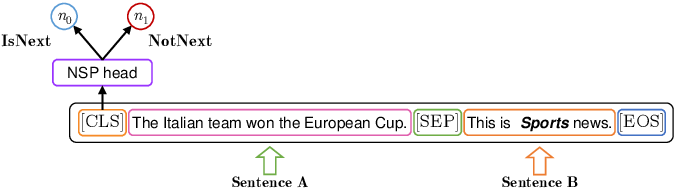


두번째로 BERT는 두 개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련합니다.

NSP 학습을 위해 여러 개의 문장으로 구성된 데이터셋을 준비합니다.

In [ ]:
from datasets import load_dataset

# Wikitext 데이터셋 불러오기
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
# 데이터셋의 구조
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [ ]:
# 학습 예시를 위한 일부 데이터 선정
data = dataset['test']['text'][:10]
data

['',
 ' = Robert Boulter = \n',
 '',
 ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n',
 ' In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill 

문장 형태의 데이터를 추출하기 위해 공백의 문자열이나 문장이 아닌 데이터들을 제외합니다.

In [ ]:
# 모델 입력을 위해 데이터 전처리 수행
text = []

for line in data:
  line = line.strip()
  if line:
    if line[0].isalpha():
      print("추출된 문장: ", line)
      text.append(line)

추출된 문장:  Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall .
추출된 문장:  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode

In [ ]:
text

['Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall .',
 'In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode of the tel

정제된 문장 리스트들을 하나의 문장들로 나누어줍니다.

In [ ]:
bag = [item for sentence in text for item in sentence.split('.') if item != '']
bag_size = len(bag)
print(bag_size)

14


In [ ]:
bag

['Robert Boulter is an English film , television and theatre actor ',
 ' He had a guest @-@ starring role on the television series The Bill in 2000 ',
 ' This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre ',
 ' He had a guest role in the television series Judge John Deed in 2002 ',
 ' In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi ',
 ' He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London ',
 ' He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall ',
 'In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill ',
 ' He appeared o

학습 레이블을 만들어주기 위해 순서가 올바른 문장 집합과 올바르지 않은 문장 집합을 50:50 비율로 생성합니다.

In [ ]:
sentence_a = []
sentence_b = []
label = []

for paragraph in text:
    sentences = [sentence for sentence in paragraph.split('.') if sentence != '']
    
    num_sentences = len(sentences)
    if num_sentences > 1:
        start = random.randint(0, num_sentences-2)
        # 50:50의 비율로 순서가 올바르거나 올바르지 않은 문장을 선정
        if random.random() >= 0.5:
            # this is IsNextSentence
            sentence_a.append(sentences[start])
            sentence_b.append(sentences[start+1])
            label.append(0)
        else:
            index = random.randint(0, bag_size-1)
            # this is NotNextSentence
            sentence_a.append(sentences[start])
            sentence_b.append(bag[index])
            label.append(1)

In [ ]:
for i in range(len(label)):
    print(label[i])
    print(sentence_a[i] + '\n---')
    print(sentence_b[i] + '\n')

1
 He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London 
---
 In May 2008 , Boulter made a guest appearance on a two @-@ part episode arc of the television series Waking the Dead , followed by an appearance on the television series Survivors in November 2008 

1
 How to Curse was performed at Bush Theatre in the London Borough of Hammersmith and Fulham 
---
 This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre 



- 순서가 올바른 문장은 0, 올바르지 않은 문장은 1의 레이블을 갖습니다.

In [ ]:
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

준비된 문장 데이터들을 tokenizer에 입력하여 토큰화를 진행합니다.

In [ ]:
inputs['labels'] = torch.LongTensor([label]).T
inputs.labels

tensor([[1],
        [1]])

In [ ]:
# NLP 작업을 위한 모델 불러오기
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

In [ ]:
# GPU 학습을 위해 모델을 선택된 device에 이동
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.train()  # 학습 모드 설정

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
dataset = Dataset(inputs)

In [ ]:
# Traning을 위한 argument 설정
args = TrainingArguments(
    output_dir='./', # 결과 정보를 받아볼 디렉토리
    per_device_train_batch_size=16, # gpu 당 batch size 수
    num_train_epochs=10 # epoch 수
)

trainer = Trainer(
    model=model, # 훈련을 수행할 모델
    args=args, # 지정한 argument
    train_dataset=dataset # 학습 데이터셋
)

In [ ]:
trainer.train()

<ipython-input-19-67611615ff7f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss


TrainOutput(global_step=10, training_loss=0.9699393272399902, metrics={'train_runtime': 2.2196, 'train_samples_per_second': 9.011, 'train_steps_per_second': 4.505, 'total_flos': 5262221107200.0, 'train_loss': 0.9699393272399902, 'epoch': 10.0})